## Import of requiered librairies

In [122]:
import os # to make directory
import tarfile  # to extract tar file
from six.moves import urllib    # to download file from internet
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


## Download the Data

In [2]:


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Fetch the data:this function fetches the data from the given URL and extracts it to the given path
# housing_url: URL to fetch the data from (default: HOUSING_URL)
# housing_path: path to extract the data to (default: HOUSING_PATH) 
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
	if not os.path.isdir(housing_path):
		os.makedirs(housing_path)
	tgz_path = os.path.join(housing_path, "housing.tgz")
	urllib.request.urlretrieve(housing_url, tgz_path)
	housing_tgz = tarfile.open(tgz_path)
	housing_tgz.extractall(path=housing_path)
	housing_tgz.close()

In [3]:
# Load the data: this function loads the data from the given path
def load_housing_data(housing_path=HOUSING_PATH):
 csv_path = os.path.join(housing_path, "housing.csv")
 return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
data_house = load_housing_data()

##  Take a Quick Look at the Data Structure

In [5]:
data_house.head() # Display the first 5 rows of the data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


the data has 10 attributes and each row represents one district 

In [6]:
data_house.info() # Display the information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


we have 20640 instances but total bedrooms has 20433 that means there are some missing values we will take care of this later.<br>
also only ocean proximity is categorical attribute

In [7]:
data_house["ocean_proximity"].value_counts() # Display the count of each category in the column "ocean_proximity"

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
data_house.describe() # Display the summary of the numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


here we can see the count , mean, min, max, the standard deviation which measures how dispersed the values are , the corresponding percentiles of the numerical attributes.<br>
Notice that the missing values are ignored so the count of total bedrooms is 20433

 Another quick way to get a feel of the type of data you are dealing with is to plot a 
histogram for each numerical attribute so let's plot **a histrogramm for all numerical attributes**

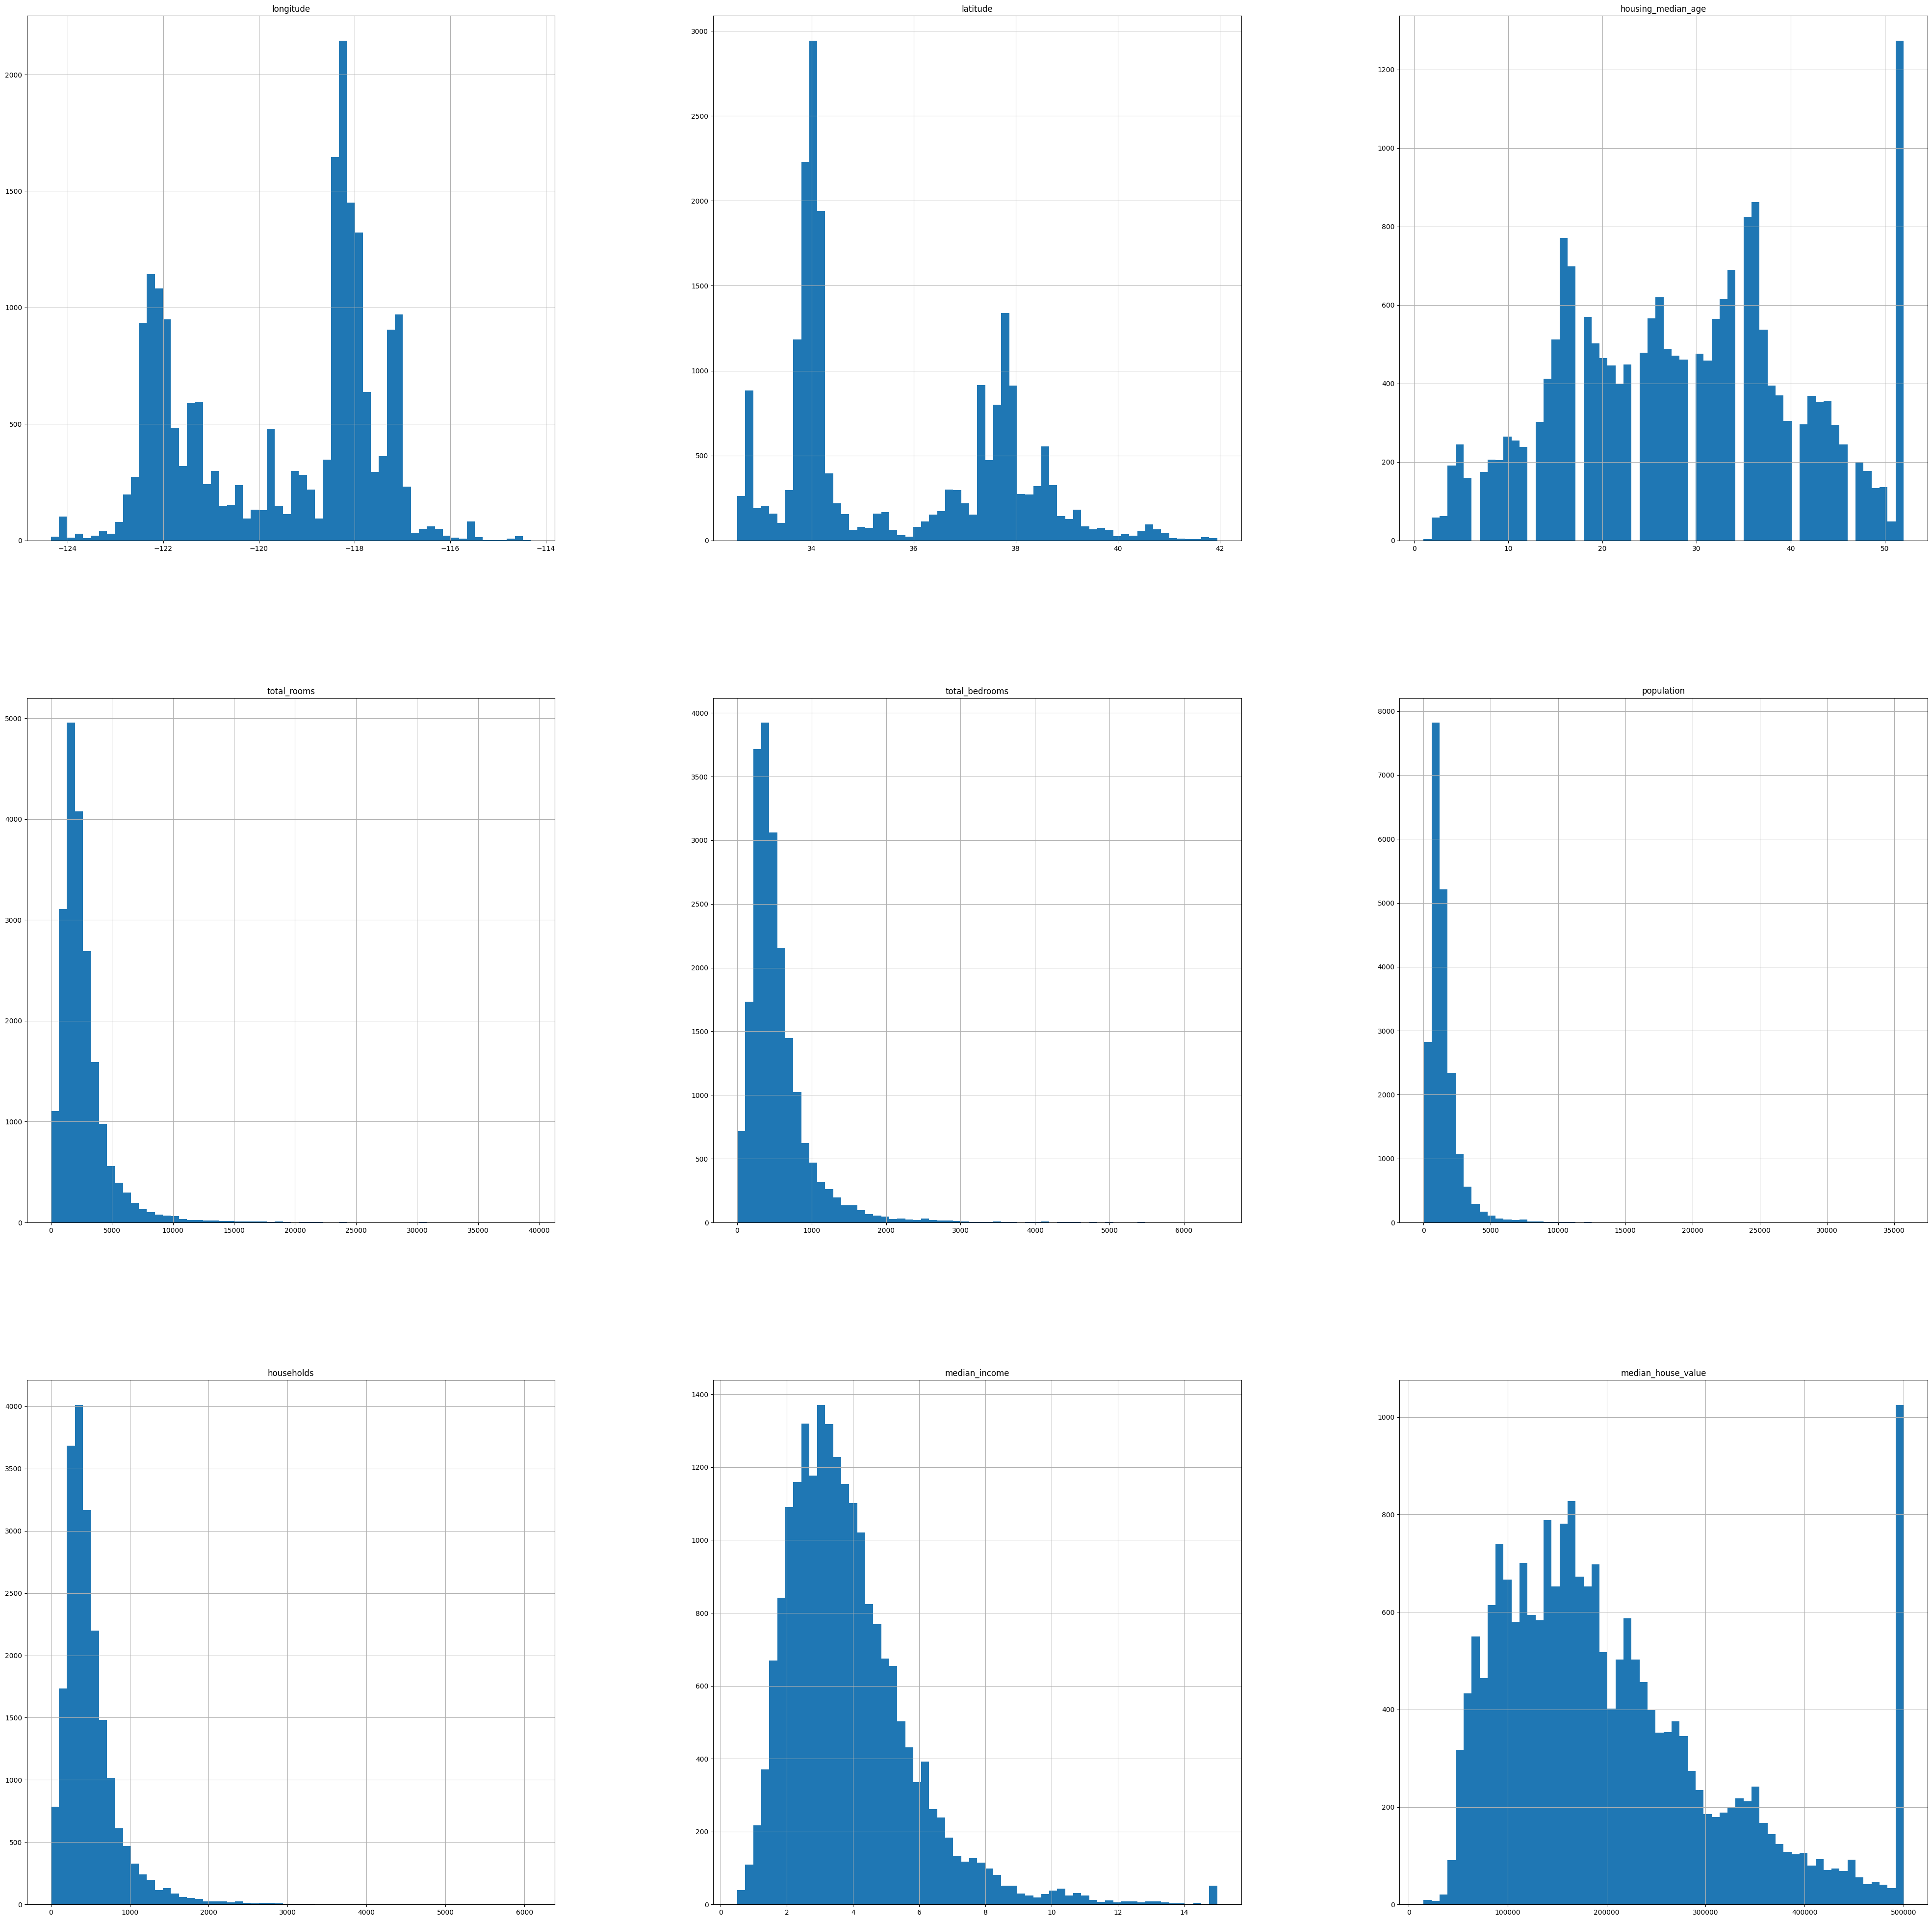

In [9]:
data_house.hist(bins=60, figsize=(50, 50)) # Display the histogram of the numerical attributes
plt.show()

- The median income attribute look like it's not expressed in US dollars , after doing rechearches the learn that data has been scaled and capped at 15 (actually 15.0001)  for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers
represent roughly tens of thousands of dollars
-  These attributes have very different scales
- Many histograms are tail-heavy, extending much farther to the right of the median than to the left. This skewness may make it more challenging for some Machine Learning algorithms to detect patterns. We will attempt to transform these attributes later to achieve more bell-shaped distributions.

## Create a Test Set

### 1.First approach to Split data

In [10]:
# Split the data into training and testing set
train_set,test_set=train_test_split(data_house, test_size=0.2, random_state=42)

here we have considered purely random sampling method. if the data isn't large enough(especially relative to the number of attriutes) we run the risk of introducing a significant bias .we must ensure that the test set represents very well our data:This is called stratified sampling.<br> 
Considered that **the median income** is a very important attribute to predict median housing prices. we may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

### Create attribute for the different  categories of median income

If we look at the median income histrogramm more closely , we will notice that most median income values are clustered around 1.5 to 6 (i.e.,$15,000–$60,000), but some median incomes go far beyond 6.<br>
It is important to have a sufficient number of instances in your dataset for each stratum,so let's uses the
 pd.cut() function to create an income category attribute with 5 categories (labeled
 from 1 to 5)

In [11]:
data_house["income_cat"]=pd.cut(data_house["median_income"],
                                bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

<Axes: >

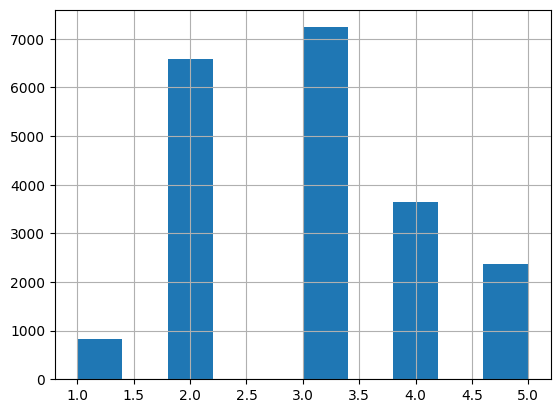

In [12]:
data_house["income_cat"].hist() # Display the histogram of the income category

Now we are ready to do stratified sampling based on the income category. 

### 2.Second approach to Split data

In [13]:
splitter=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # Create an instance of StratifiedShuffleSplit

for train_indice, test_indice in splitter.split(data_house, data_house["income_cat"]): # Split the data into training and testing set
    train_set=data_house.loc[train_indice] 
    test_set=data_house.loc[test_indice]

In [14]:
# income categories proportion in the data set
test_set["income_cat"].value_counts()/len(data_house)

income_cat
3    0.070107
2    0.063760
4    0.035271
5    0.022868
1    0.007994
Name: count, dtype: float64

Now we would remove  income_cat attribute on test and training set

In [15]:
# Remove the income_cat attribute from train and test sets
for donnee in (train_set, test_set):
    donnee.drop("income_cat", axis=1, inplace=True)

## Discover Visualize the Data to Gain Insights

Let’s create a copy so we can play with it without harming the training set:

In [16]:
data_house=train_set.copy() # Create a copy of the training set

### Visualizing Geagraphical Data

let's lookt at house prices with respect to the geographical location , the radius of each circle represents the population of the district and the color represents the price

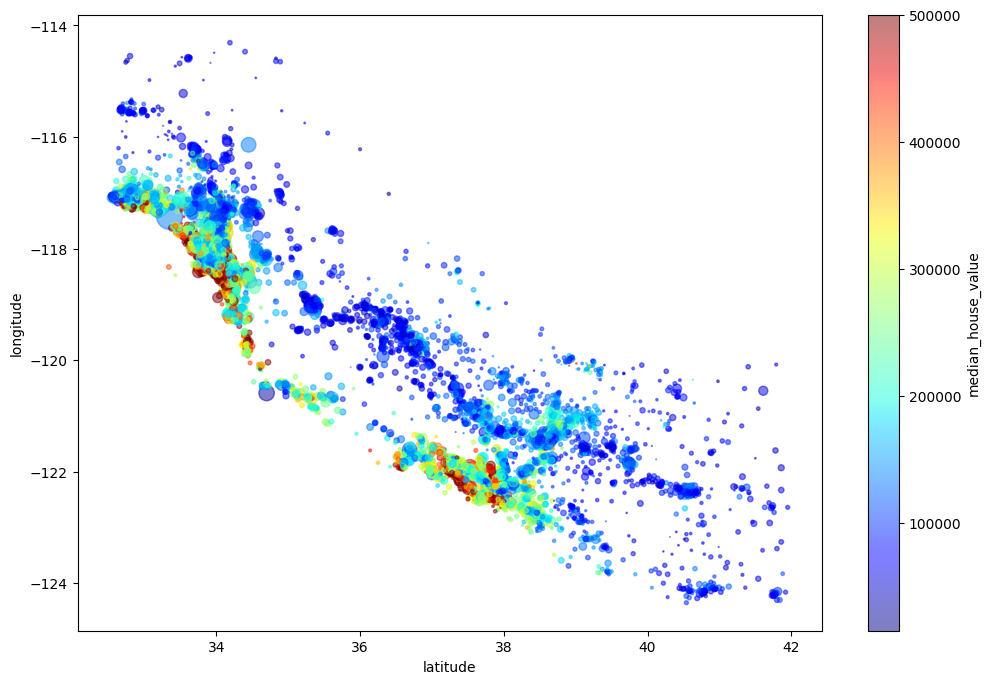

In [17]:
# let's lookt at house prices with respect to the geographical location , the radius of each circle represents the population of the district and the color represents the price
plt.figure(figsize=(12, 8)) # Create a figure
plt.scatter(data_house["latitude"], data_house["longitude"], alpha=0.5, s=data_house["population"]/100, c=data_house["median_house_value"], cmap="jet") # Create a scatter plot
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.colorbar(label="median_house_value")

The image tells us that the housing prices that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density

###  Looking for Correlations

In [ ]:
numeric_data=data_house.select_dtypes(include=["number"]) # Select the numerical attributes 

In [ ]:
corr_matrix=numeric_data.corr()  # Compute the correlation matrix

In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False) # Display the correlation of each attribute with the median house value

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

There are a strong positive correlation between  median house value and  median income , it means that , the median house value tends to go up when the median income goes up.<br>
we can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north)

Use Panda's **scatter_matrix function** is another way to check for correlation between attributes.<br>
It's plots every numerical attribute against every other
numerical attribute, let’s just focus on a few promising
 attributes that seem most correlated with the median housing value

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

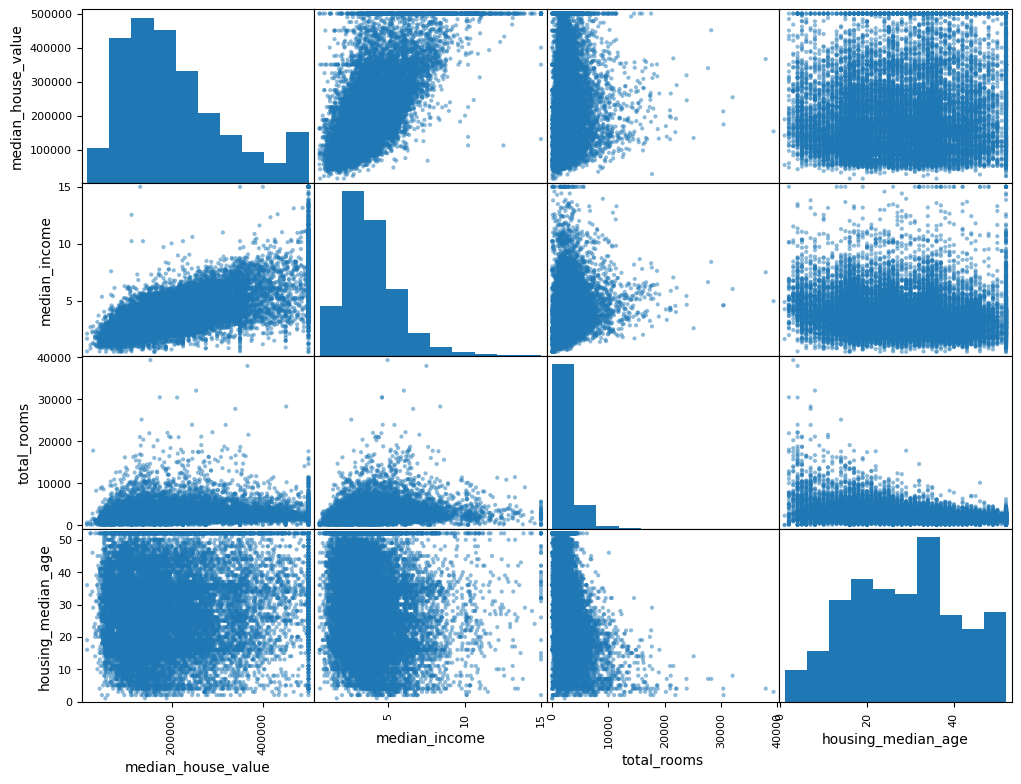

In [22]:
scatter_matrix(data_house[["median_house_value", "median_income", "total_rooms", "housing_median_age"]], figsize=(12,9)) # Display the scatter matrix of the selected attributes

 The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

<Axes: xlabel='median_income', ylabel='median_house_value'>

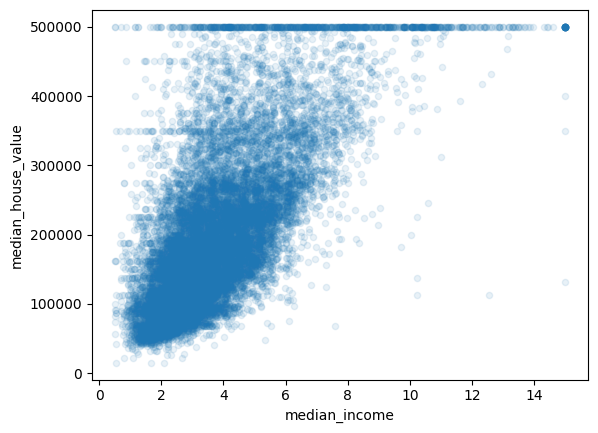

In [30]:
numeric_data.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)

This plot reveals several insights. Firstly, the correlation is quite strong, as evidenced by the clear upward trend and the relatively tight clustering of points. Secondly, the price cap we observed earlier is apparent as a horizontal line at $500,000. Additionally, the plot reveals other less obvious horizontal lines: one around $450,000, another around $350,000, possibly one around $280,000, and a few more below that. To prevent our algorithms from learning these data quirks, we might consider removing the corresponding districts.

 ## Features ingineering (Experimenting with Attribute Combinations)

 the total number of rooms in a district is not very useful if you don’t know how many households there are. What WE really want is the number of rooms per household.
 Similarly, the total number of bedrooms by itself is not very useful: WE probably want to compare it to the number of rooms. And the population per household also
 seems like an interesting attribute combination to look at. Let’s create these new
 attributes:

In [31]:
data_house["rooms_per_household"]=data_house["total_rooms"]/data_house["households"] # Create a new attribute "rooms_per_household"
data_house["bedrooms_per_room"]=data_house["total_bedrooms"]/data_house["total_rooms"] # Create a new attribute "bedrooms_per_room"
data_house["population_per_household"]=data_house["population"]/data_house["households"] # Create a new attribute "population_per_household"

In [33]:
# let's look at the correlation matrix
corr_matrix=data_house.select_dtypes(["number"]).corr() 
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Great observation! The new bedrooms_per_room attribute shows a much stronger correlation with the median house value compared to the total number of rooms or bedrooms. It seems that houses with a lower bedroom-to-room ratio tend to be more expensive. Similarly, the rooms_per_household attribute provides more meaningful information than the total number of rooms in a district—larger houses are naturally associated with higher prices.


##  Prepare the Data for Machine Learning Algorithms

### Separation of prediction target from features

In [34]:
data_house=train_set.drop("median_house_value",axis=1) # Create a copy of the training set without the target attribute
data_house_labels=train_set["median_house_value"].copy() # Create a copy of the target attribute

### Data Cleaning

Most Machine Learning cannot work very well with missing features .So let's take care of them .<br>
we noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this

In [36]:
imputer=SimpleImputer(strategy="median") # Create an instance of SimpleImputer
numeric_data=data_house.select_dtypes(["number"]) # Select the numerical attributes
imputer.fit(numeric_data) # Fit the imputer to the data

SimpleImputer(strategy='median')

The imputer has calculated the median for each attribute and stored these values in its statistics_ instance variable. While only the total_bedrooms attribute had missing values in the current dataset, there is no guarantee that new data won't have missing values in other attributes once the system is live. Therefore, it is safer to apply the imputer to all numerical attributes.

In [38]:
imputer.statistics_  # Display the median of each attribute

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now just need to use this “trained” imputer to transform the training set by replacing missing values by the learned medians

In [39]:
X=imputer.transform(numeric_data) # Transform the data

In [40]:
data_house_transform=pd.DataFrame(X,columns=numeric_data.columns) # Create a DataFrame from the transformed data

###  Handling Text and Categorical Attributes

In [ ]:

ordinal_encoder=OrdinalEncoder()

In [43]:
data_house_cat=data_house[["ocean_proximity"]] # Select the categorical attribute
data_house_cat.head() # Display the first 5 rows of the data

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


Most Machine Learning algorithms are designed to work with numerical data. Therefore, we need to convert these categorical attributes from text to numbers. To achieve this, we can use Scikit-Learn's OrdinalEncoder class.

In [ ]:
ordinal_encoder = OrdinalEncoder()  # Create an instance of OrdinalEncoder
data_house_cat_encoded = ordinal_encoder.fit_transform(data_house_cat)  # Encode the categorical attribute
data_house_cat_encoded[:10]  # Display the first 10 rows of the encoded data

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [46]:
ordinal_encoder.categories_ # Display the categories of the categorical attribute

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One limitation of this representation is that Machine Learning algorithms may interpret nearby values as being more similar than distant ones. While this might work for ordered categories (e.g., "bad," "average," "good," "excellent"), it is not suitable for the ocean_proximity column. For instance, categories 0 and 4 are more similar than categories 0 and 1, which the algorithm would not understand.<br>
To address this, a common approach is to create one binary attribute for each category Only one attribute is "hot" (1) at a time, while the rest are "cold" (0).<br>
This avoids misleading similarity assumptions.

Scikit-Learn's OneHotEncoder class can be used to convert categorical values into one-hot encoded vectors.

In [48]:
cat_encoder=OneHotEncoder() # Create an instance of OneHotEncoder
data_house_cat_hot=cat_encoder.fit_transform(data_house_cat) # Encode the categorical attribute

In [50]:
data_house_cat_hot.toarray() # Display the encoded data

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [51]:
cat_encoder.categories_ # Display the categories of the categorical attribute

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [53]:
 # let us create a custom transformer to add the new attributes
from sklearn.base import BaseEstimator , TransformerMixin 

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class combined_attribut_adder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True ):
        self.add_bedrooms_per_room=add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household=X[:, rooms_ix]/X[:, households_ix]
        population_per_household=X[:, population_ix]/X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,  bedrooms_per_room]
                                                      
        else:
              return np.c_[X, rooms_per_household, population_per_household]

In this example, the transformer includes a hyperparameter, add_bedrooms_per_room, which is set to True by default (providing sensible defaults is often beneficial). This hyperparameter allows us to easily test whether adding this attribute improves the performance of the Machine Learning algorithms. More broadly, we can use hyperparameters to control any data preparation step that we are uncertain about, enabling flexibility and experimentation.

###  Feature Scaling

 many machine learning algorithms perform poorly when the input numerical attributes have very different scales. This is the case for the housing data set. We will use the standardScaler to scale the numerical attributes

In [ ]:
# let us create a pipeline for the numerical attributes


In [55]:
num_pipeline=Pipeline([
               ("imputer", SimpleImputer(strategy="median")),  # impute the missing values
               ("add_attribute", combined_attribut_adder()),  # add the new attributes
               ("std_scaler", StandardScaler()),  # standardize the data
                                                              ])

In [56]:
data_house_numeric_transform=num_pipeline.fit_transform(numeric_data)

So far, we have handled the numerical attributes and the categorical attributes separately. It would be more convenient to have a single transformer to handle all columns, applying the appropriate transformations to each column. To do this, we can use the ColumnTransformer class from Scikit-Learn. The constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names (or indices) of columns that the transformer should be applied to. In the following code, we apply the numerical pipeline to the numerical attributes and the OneHotEncoder to the categorical attributes. We obtain a full pipeline that applies the appropriate transformations to each column.

In [ ]:
num_attributes = list(numeric_data) # list of numerical attributes
cat_attribute=["ocean_proximity"] # list of categorical attributes

In [59]:
full_pipeline= ColumnTransformer([
    ("num", num_pipeline, num_attributes), # apply the pipeline to the numerical attributes
    ("cat", OneHotEncoder(), cat_attribute), # apply OneHotEncoder to the categorical attributes
])

In [60]:
data_house_prepared=full_pipeline.fit_transform(data_house) 

##  Select and Train a Model

### Training and Evaluating on the Training Set

#### Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression # import the LinearRegression model
lin_reg=LinearRegression() # Create an instance of LinearRegression
lin_reg.fit(data_house_prepared, data_house_labels) # Fit the model to the data

LinearRegression()

Let’s try the model out on a few instances from the training set:

In [66]:
some_data=data_house.iloc[:5] # Select the first 5 rows of the data
some_data_labels=data_house_labels.iloc[:5] # Select the first 5 rows of the target attribute
some_data_prepared=full_pipeline.transform(some_data) # Transform the data

In [68]:
print(f"Prediction: {lin_reg.predict(some_data_prepared)}\n")
print(f"labels: {list(some_data_labels)}")

Prediction: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]

labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


The model works, but the predictions are not very accurate (e.g., the first prediction is off by nearly 40%). To evaluate the performance of this regression model, we can calculate its Root Mean Squared Error (RMSE) on the entire training set using Scikit-Learn's mean_squared_error function.

In [70]:
from sklearn.metrics import mean_squared_error # import the mean_squared_error function
data_house_predictions=lin_reg.predict(data_house_prepared) # Make predictions

In [ ]:
lin_mse=mean_squared_error(data_house_labels, data_house_predictions) # Compute the mean squared error
lin_rsme=np.sqrt(lin_mse) 
lin_rsme

np.float64(68627.87390018745)

While this result is better than nothing, it is far from ideal: the median housing values for most districts range between $120,000 and $265,000, making a typical prediction error of $68,628 quite unsatisfactory. This indicates that the model is underfitting the training data. So let's train a more powerful model.

#### Decision Tree

In [72]:
from sklearn.tree import DecisionTreeRegressor  # import the DecisionTreeRegressor model
tree_re=DecisionTreeRegressor() # Create an instance of DecisionTreeRegressor
tree_re.fit(data_house_prepared, data_house_labels)

DecisionTreeRegressor()

In [74]:
data_house_predictions=tree_re.predict(data_house_prepared) # Make predictions
tree_mse=mean_squared_error(data_house_predictions, data_house_labels) # Compute the mean squared error
tree_rmse=np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

Wait, what!? No error at all? Could this model really be perfect? It's far more likely that the model has severely overfit the training data.<br>
let's evaluate the model using Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score # import the cross_val_score function
score=cross_val_score(tree_re, data_house_prepared, data_house_labels, 
                      scoring="neg_mean_squared_error", cv=10) 
tree_score_rmse=np.sqrt(-score) 

In [76]:
# create a function to display the scores
def print_score(score):
    print(f"SCORE: {score}\n")
    print(f"MOYENNE: {score.mean()}\n")
    print(f"ECART TYPE: {score.std()}")

In [77]:
print_score(tree_score_rmse)

SCORE: [72384.1299764  70341.12773741 69913.03216534 72169.52655114
 68558.53619409 76843.31238671 71236.4914019  73998.73453442
 68655.08322575 71085.8948035 ]

MOYENNE: 71518.5868976656

ECART TYPE: 2384.7283057780583


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model.<br>
Let’s compute the same scores for the Linear Regression model just to be sure

In [80]:
lin_score=cross_val_score(lin_reg, data_house_prepared, data_house_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse=np.sqrt(-lin_score)
print_score(lin_rmse)

SCORE: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]

MOYENNE: 69104.07998247063

ECART TYPE: 2880.3282098180666


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

#### Random Forest 

In [81]:
from sklearn.ensemble import RandomForestRegressor
forest_re=RandomForestRegressor()
forest_re.fit(data_house_prepared, data_house_labels)

RandomForestRegressor()

In [82]:
data_house_predictions=forest_re.predict(data_house_prepared) 
forest_sme=mean_squared_error(data_house_predictions, data_house_labels) 
forest_rmse=np.sqrt(forest_sme)
forest_rmse

np.float64(18742.949748114424)

In [83]:
forest_score=cross_val_score(forest_re, data_house_prepared, data_house_labels,
                             scoring="neg_mean_squared_error", cv=10)

In [84]:
forest_rmse_score=np.sqrt(-forest_score)
print_score(forest_rmse_score)

SCORE: [51336.34831536 49370.92432645 46748.26737032 51907.00688965
 47786.14848016 52069.9901213  52520.11098869 49705.95283253
 48469.90206472 53751.70334602]

MOYENNE: 50366.63547352039

ECART TYPE: 2169.9697270934357


Wow, this is a significant improvement—Random Forests seem very promising. However, the training set score is still much better than the validation set scores, indicating that the model is still overfitting the training data.

#### Support Vector Machine

In [85]:
from sklearn.svm import SVR # import the SVR model
svr=SVR() # Create an instance of SVR
svr.fit(data_house_prepared, data_house_labels) # Fit the model to the data

SVR()

In [87]:
data_house_predictions=svr.predict(data_house_prepared) # Make predictions
svr_sme=mean_squared_error(data_house_predictions, data_house_labels) # Compute the mean squared error
svr_rmse=np.sqrt(svr_sme)
svr_rmse

np.float64(118578.69234925653)

In [88]:
score_svr=cross_val_score(svr, data_house_prepared, data_house_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_score=np.sqrt(-score_svr)
print_score(svr_rmse_score)

SCORE: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]

MOYENNE: 118584.55594251942

ECART TYPE: 2609.6120823493407


The SVC perform poorly on both train and test set . That's probably a case on underfitting. the will come back on this later

#### XGBOOST

In [89]:
import xgboost as xgb # import the xgboost library
xgb_re=xgb.XGBRegressor() # Create an instance of XGBRegressor
xgb_re.fit(data_house_prepared, data_house_labels) # Fit the model to the data

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [90]:
data_house_predictions=xgb_re.predict(data_house_prepared) # Make predictions
xgb_sme=mean_squared_error(data_house_predictions, data_house_labels) # Compute the mean squared error
xgb_rmse=np.sqrt(xgb_sme)
xgb_rmse

np.float64(25888.504960450548)

In [92]:
score_xgb=cross_val_score(xgb_re, data_house_prepared, data_house_labels, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_score=np.sqrt(-score_xgb)
print_score(xgb_rmse_score)

SCORE: [47823.18546147 45470.5582399  43207.50875019 48761.32576352
 44916.43261899 49318.72374954 48364.82678236 46391.83058714
 45218.3406267  50114.3068967 ]

MOYENNE: 46958.70394765158

ECART TYPE: 2128.581774210985


That's great the XGBOOST perfrom better , but also presents a case of overfitting

### Fine-Tune  Models

let us tune the hyperparameters of the RandomForestRegressor , svc and xgb models . for this we will use Grid Search

#### Random Forest 

In [95]:
# define the grid of hyperparameters
param_gri=[
    { "n_estimators": [3, 10, 30], "max_features":[2, 4, 6, 8]},
    {"bootstrap":[False], "n_estimators":[3, 10, 30], "max_features":[2, 3, 4, 8]}
]

In [96]:
forest_reg=RandomForestRegressor()
# Create an instance of GridSearchCV
grid_search= GridSearchCV( forest_re, param_gri, cv=5,
                         scoring="neg_mean_squared_error",
                         return_train_score=True) 

In [97]:
grid_search.fit(data_house_prepared, data_house_labels) # Fit the model to the data

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [98]:
grid_search.best_params_ # Display the best hyperparameters

{'bootstrap': False, 'max_features': 4, 'n_estimators': 30}

In [99]:
grid_search.best_estimator_ # Display the best estimator

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [104]:
sc=grid_search.cv_results_ # Display the scores

In [105]:
for mean_sc , param in zip(sc["mean_test_score"], sc["params"]):
    print(f"SCORE: {np.sqrt(-mean_sc)}, {param}\n ")

SCORE: 65081.87324500351, {'max_features': 2, 'n_estimators': 3}
 
SCORE: 55447.01127560522, {'max_features': 2, 'n_estimators': 10}
 
SCORE: 52506.8725746827, {'max_features': 2, 'n_estimators': 30}
 
SCORE: 59952.14249427555, {'max_features': 4, 'n_estimators': 3}
 
SCORE: 53079.62435388141, {'max_features': 4, 'n_estimators': 10}
 
SCORE: 50201.0639059599, {'max_features': 4, 'n_estimators': 30}
 
SCORE: 59233.39658643434, {'max_features': 6, 'n_estimators': 3}
 
SCORE: 52182.8908737676, {'max_features': 6, 'n_estimators': 10}
 
SCORE: 49960.604001801024, {'max_features': 6, 'n_estimators': 30}
 
SCORE: 58913.87254643525, {'max_features': 8, 'n_estimators': 3}
 
SCORE: 52354.34133860514, {'max_features': 8, 'n_estimators': 10}
 
SCORE: 50052.559089350456, {'max_features': 8, 'n_estimators': 30}
 
SCORE: 62392.644137153526, {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
 
SCORE: 54110.26585553745, {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
 
SCORE: 51915.

In this example, the best results are achieved by setting the max_features hyperparameter to 8 and the n_estimators hyperparameter to 30. This combination yields an RMSE score of 49,310, which is a slight improvement over the previous score of 46,958 obtained with the default hyperparameter values.

In [107]:
best_forest_re=grid_search.best_estimator_ # Create an instance of the best estimator

#### SVC

In [ ]:
param_grid = [
    {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Try different kernels
        "C": [0.1, 1, 10, 100],  # Regularization parameter
        "gamma": ["scale", "auto", 0.1, 0.01, 0.001],  # Kernel coefficient
        "degree": [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly')
    }
]
random_search = RandomizedSearchCV(svr, param_distributions=param_grid, n_iter=30, cv=5, scoring="neg_mean_squared_error", random_state=42)
random_search.fit(data_house_prepared, data_house_labels)

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=30,
                   param_distributions=[{'C': [0.1, 1, 10, 100],
                                         'degree': [2, 3, 4],
                                         'gamma': ['scale', 'auto', 0.1, 0.01,
                                                   0.001],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   random_state=42, scoring='neg_mean_squared_error')

In [123]:
sc=random_search.cv_results_ # Display the scores
for mean_sc , param in zip(sc["mean_test_score"], sc["params"]):
    print(f"SCORE: {np.sqrt(-mean_sc)}, {param}\n ")

SCORE: 118258.82445795466, {'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'C': 0.1}
 
SCORE: 118905.98565388561, {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 0.1}
 
SCORE: 118937.0241786995, {'kernel': 'poly', 'gamma': 0.01, 'degree': 3, 'C': 1}
 
SCORE: 125697.07930099651, {'kernel': 'poly', 'gamma': 0.1, 'degree': 4, 'C': 1}
 
SCORE: 112571.06378605746, {'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'C': 1}
 
SCORE: 84649.6069847477, {'kernel': 'linear', 'gamma': 0.01, 'degree': 4, 'C': 10}
 
SCORE: 119348.49523400354, {'kernel': 'poly', 'gamma': 0.01, 'degree': 4, 'C': 100}
 
SCORE: 118639.96425886606, {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 1}
 
SCORE: 118918.57580545293, {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 0.1}
 
SCORE: 114119.8185202349, {'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 3, 'C': 10}
 
SCORE: 119453.64991371999, {'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'C': 0.1}
 
SCORE: 97940.27774093515, {'kernel': 'rbf', 'gamma

In [120]:
svr_best=random_search.best_estimator_ # Create an instance of the best estimator
svr_best

SVR(C=10, degree=4, gamma=0.01, kernel='linear')

In [121]:
y_pred=svr_best.predict(data_house_prepared) # Make predictions
svr_sme=mean_squared_error(y_pred, data_house_labels) # Compute the mean squared error
svr_rmse=np.sqrt(svr_sme)
svr_rmse

np.float64(81932.39323149915)

That's a slight improvement over the previous score obtained with the default hyperparameter values.But yhe model still underfit the data.<br> 
Let's turn the parameters of xgboost

#### XGBOOST

In [124]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

In [140]:
random_search_xg = RandomizedSearchCV(xgb_re, param_distributions=param_grid, n_iter=40, cv=5, scoring="neg_mean_squared_error", random_state=42)
random_search_xg.fit(data_house_prepared, data_house_labels)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=40,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 10, 100],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [141]:
random_search.best_params_ # Display the best hyperparameters

{'subsample': 1.0,
 'reg_lambda': 10,
 'reg_alpha': 0,
 'n_estimators': 300,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [142]:
sc = random_search.cv_results_ # Display the scores
for mean_sc, param in zip(sc["mean_test_score"], sc["params"]):
    print(f"SCORE: {np.sqrt(-mean_sc)}, {param}\n ")

SCORE: 47972.13540390781, {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
 
SCORE: 77537.6717470023, {'subsample': 0.8, 'reg_lambda': 100, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
 
SCORE: 47675.56886987734, {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
 
SCORE: 45011.70011271889, {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
 
SCORE: 51829.23254382195, {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
 
SCORE: 61815.35360252823, {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
 
SC

In this example, the best results are achieved with a score of 44822,which is a slight improvement over the previous score of 46958 obtained with the default hyperparameter values.

In [143]:
best_xgb_re = random_search.best_estimator_ # Create an instance of the best estimator

### Ensemble Methods

we will combine Xgboost and Random forest. 

In [135]:
from sklearn.ensemble import VotingRegressor

# Create the ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('random_forest', best_forest_re),  # Best Random Forest model
    ('xgboost', xgb_re)  # XGBoost model
])

# Fit the ensemble model to the prepared data
ensemble_model.fit(data_house_prepared, data_house_labels)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(bootstrap=False,
                                                   max_features=4,
                                                   n_estimators=30)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...))])

In [136]:
# Evaluate the ensemble model using cross-validation
ensemble_score = cross_val_score(ensemble_model, data_house_prepared, data_house_labels, scoring="neg_mean_squared_error", cv=10)
ensemble_rmse_score = np.sqrt(-ensemble_score)
print_score(ensemble_rmse_score)

SCORE: [47889.23165325 44728.10390007 42617.21398305 47682.49447521
 44281.13718387 47154.56117047 47931.00383779 45425.14295072
 44204.79238885 50213.45502705]

MOYENNE: 46212.71365703364

ECART TYPE: 2198.435461485933


**Notice** that the XGBOOST perform better than the combined models so the best model is **XGBOOST

### Analyze the Best Models and Their Errors

In [144]:
features_importance=random_search_xg.best_estimator_.feature_importances_ # Display the features importance
features_importance 

array([0.02221784, 0.02433758, 0.0150059 , 0.00492771, 0.0058817 ,
       0.00571488, 0.00708555, 0.16693176, 0.0223301 , 0.03556157,
       0.01611538, 0.01588271, 0.62398607, 0.        , 0.01215233,
       0.0218689 ], dtype=float32)

 Let’s display these importance scores next to their corresponding attribute names:

In [145]:
extra_attributes=["rooms_per_household", "population_per_household", "bedrooms_per_room"] # list of extra attributes
cat_encoder=full_pipeline.named_transformers_["cat"]; # get the OneHotEncoder
cat_one_encoder=list(cat_encoder.categories_[0]) # get the categories of the categorical attribute
attributes=num_attributes+extra_attributes+cat_one_encoder # list of attributes
sorted(zip(features_importance, attributes), reverse=True) # Display the features importance

[(np.float32(0.62398607), 'INLAND'),
 (np.float32(0.16693176), 'median_income'),
 (np.float32(0.035561573), 'population_per_household'),
 (np.float32(0.024337582), 'latitude'),
 (np.float32(0.022330103), 'rooms_per_household'),
 (np.float32(0.022217836), 'longitude'),
 (np.float32(0.021868901), 'NEAR OCEAN'),
 (np.float32(0.016115382), 'bedrooms_per_room'),
 (np.float32(0.015882712), '<1H OCEAN'),
 (np.float32(0.0150059), 'housing_median_age'),
 (np.float32(0.012152329), 'NEAR BAY'),
 (np.float32(0.0070855515), 'households'),
 (np.float32(0.0058816974), 'total_bedrooms'),
 (np.float32(0.0057148803), 'population'),
 (np.float32(0.004927709), 'total_rooms'),
 (np.float32(0.0), 'ISLAND')]

let's drop the 4 less important features and retrain the model

In [148]:
# Convert the prepared data to a DataFrame
data_prepared_df = pd.DataFrame(data_house_prepared, columns=attributes)

# Drop the 4 least important attributes
data_house_prepared_reduced = data_prepared_df.drop(['ISLAND', 'total_rooms', 'population', 'total_bedrooms', 'households'], axis=1)

data_house_prepared_reduced.head()  # Display the first few rows of the updated DataFrame

,longitude,latitude,housing_median_age,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-0.941350,1.347438,0.027564,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0


In [151]:
# Rename columns to ensure valid feature names
data_house_prepared_reduced.columns = [col.replace('<', '').replace('>', '').replace(' ', '_') for col in data_house_prepared_reduced.columns]

# Fit the model and evaluate
best_xgb_re.fit(data_house_prepared_reduced, data_house_labels) # Fit the model to the data
score_xgb_reduced = cross_val_score(best_xgb_re, data_house_prepared_reduced, data_house_labels, scoring="neg_mean_squared_error", cv=10) # Evaluate the model using cross-validation
xgb_rmse_reduced = np.sqrt(-score_xgb_reduced) # Compute the RMSE
print_score(xgb_rmse_reduced) # Display

SCORE: [46536.45891111 44001.75902491 41166.54305576 46019.72098741
 42395.9787531  44210.62838212 46628.35892552 43243.48312905
 43506.47065635 48409.54698163]

MOYENNE: 44611.89488069824

ECART TYPE: 2111.4624614946915


the model perform slighly better by droppind the less important feature

In [153]:
# let us create a function to prepare the data
def prepare_data(dataset, transformer, columns_to_drop=['ISLAND', 'total_rooms', 'population', 'total_bedrooms', 'households']):
    """
    Prepares the dataset by applying the transformer, converting the transformed data to a DataFrame,
    and dropping specified columns.

    Parameters:
    - dataset: The input dataset to be transformed.
    - transformer: The transformer to be applied to the dataset.
    - columns_to_drop: List of columns to drop from the transformed dataset.

    Returns:
    - A DataFrame with the prepared data.
    """
    # Apply the transformer to the dataset
    transformed_data = transformer.transform(dataset)
    
    # Convert the transformed data to a DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=attributes)
    
    # Drop the specified columns
    prepared_data = transformed_df.drop(columns=columns_to_drop, errors='ignore')
    prepared_data.columns = [col.replace('<', '').replace('>', '').replace(' ', '_') for col in data_house_prepared_reduced.columns]
    
    return prepared_data

In [154]:
final_model=best_xgb_re # Create the final model

 ### Evaluate the model on the Test Set

In [155]:
x_test=test_set.drop("median_house_value", axis=1) # Create a copy of the test set without the target attribute
y_test=test_set["median_house_value"].copy() # Create a copy of the target attribute

In [156]:
x_test_set_prepared=prepare_data(x_test, full_pipeline) # Prepare the test set

In [157]:
test_set_prediction=final_model.predict(x_test_set_prepared) # Make predictions

In [158]:
final_mse=mean_squared_error(test_set_prediction, y_test)
final_rmse=np.sqrt(final_mse)
final_rmse

np.float64(43138.18281938381)

In [162]:
# let's copute the 95% confidence interval for the predictions
from scipy import stats

In [163]:
confidence=0.95
squared_error=(test_set_prediction - y_test)**2
confident_in=np.sqrt(stats.t.interval( confidence, 
                                      len(squared_error)-1,
                                     loc=squared_error.mean(),
                                     scale=stats.sem(squared_error)))

In [164]:
confident_in

array([41226.73142568, 44968.45838887])

The model's performance shows that the RMSE on the test set is 43,138, while the RMSE on the validation set is 44,611. This indicates that the model generalizes reasonably well, as the scores on the test and validation sets are close to each other, which suggests that the model is not overfitting and is able to generalize well to unseen data.<br>
The system's final performance does not surpass that of the experts, but it could still be worth deploying. Automating this task might allow the experts to focus on more valuable and engaging work, increasing overall productivity.

### Save the Model

In [165]:
import joblib # import the joblib library to save the model
# Save the model
joblib.dump(final_model, "final_model.pkl") # Save the model to a file

['final_model.pkl']